# Getting started

* This notebook shows some basic usage of CapyMOA for supervised learning (classification and regression)
* There are more detailed notebooks and documentation available (see link below), our goal here is just present some high-level functions and demonstrate a subset of CapyMOA's functionalities. 
* For simplicity, we simulate data streams in the following examples by reading data from files and employing synthetic generators.

CapyMOA complete documentation is available on: LINK_CAPYMOA_ORG

**last update on 08/04/2024**

## 0. CapyMOA import and reading data 

In [1]:
# importing the file reader functionality and setting a path for the data used in the examples. 
from capymoa.stream.stream import stream_from_file

DATA_PATH = "../data/"

## Creating the stream used in all Classification examples. 
elec_stream = stream_from_file(path_to_csv_or_arff=DATA_PATH+"electricity.csv")

## Creating the stream used in all Regression examples. Note that we are using an arff file instead of a CSV. 
fried_stream = stream_from_file(path_to_csv_or_arff=DATA_PATH+"fried.arff")

capymoa_root: /Users/gomeshe/Dropbox/ciencia_computacao/dev/main-projects/CapyMOA/src/capymoa
MOA jar path location (config.ini): /Users/gomeshe/Dropbox/ciencia_computacao/dev/main-projects/CapyMOA/src/capymoa/jar/moa.jar
JVM Location (system): 
JAVA_HOME: /Users/gomeshe/Library/Java/JavaVirtualMachines/openjdk-20.0.1/Contents/Home
JVM args: ['-Xmx8g', '-Xss10M']
Sucessfully started the JVM and added MOA jar to the class path


## 1. Classification

* Classification for data streams tradicionally assumes instances are available to the classifier in an incremental fashion and labels become available before a new instance becomes available
* It is common to simulate this behavior using a **while loop**, often referred to as **test-then-train loop** which contains 4 distinct steps:
    1. Fetches the next instance from the stream
    2. Makes a prediction
    3. Train the model with the instance
    4. Update a mechanism to keep track of metrics


**Some remarks about test-then-train loop**:
* We **must not train before testing**, meaning that steps 2 and 3 should not be interchanged, as this would invalidate our interpretation concerning how the model performs on unseen data, leading to unreliable evaluations of its efficacy. 
* Steps 3 and 4 can be completed in any order without altering the result. 
* What if labels are not immediately available? Then you might want to read about delayed labeling and partially labeled data, see [A Survey on Semi-supervised Learning for Delayed Partially Labelled Data Streams](https://dl.acm.org/doi/full/10.1145/3523055) [See SSL_example.ipynb ]
* More information on classification for data streams is available on section *2.2 Classification* from [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book


In [2]:
## Test-then-train loop example
from capymoa.evaluation import ClassificationEvaluator
from capymoa.learner.classifier import OnlineBagging

# Creating a learner
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)

# Creating the evaluator, i.e. object that keeps track of metrics
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    # Step 1: fetch a new instance from the stream
    instance = elec_stream.next_instance()

    # Step 2: make a prediction
    prediction = ob_learner.predict(instance)
    
    # Step 3: train the model using the instance
        # Assumes the label became available for this instance. Note that this is a simulation, 
        # this step can be a bit more complex in a real setting or when labels are delayed. 
    ob_learner.train(instance)

    # Step 4: uses the prediction made earlier to update metrics. 
        # The evaluator object records the correct and incorrect predictions and updates several metrics. 
    ob_evaluator.update(instance.y_index, prediction)

# Prints the accuracy of the learner through the evaluator object. 
print(ob_evaluator.accuracy())

79.05190677966102


### 1.1 High-level evaluation functions

* If our goal is just to evaluate learners it would be tedious to keep writing the **test-then-train loop**. 
Thus, it makes sense to encapsulate that loop inside **high-level evaluation functions**. 

* Furthermore, sometimes we are interested on **cumulative metrics** and sometimes we care about metrics **windowed metrics**. For example, if we want to know how accurate our model is so far, considering all the instances it has seen, then we would look at its cumulative metrics. However, we might also be interested on how well the model is every **n** number of instances, so that we can, for example, identify periods in which our model was really struggling to produce correct predictions. 

* In this example, we use the ```prequential_evaluation``` function, which provides us with both the cumulative and the windowed metrics! If you are only interested on the test-then-train evaluation or the windowed evaluation, there are high-level functions for those as well (see the remarks below). 

* Some remarks:
    * If you want to know more about other **high-level evaluation functions**, **evaluators**, or which **metrics** are available, check the complete **Evaluation documentation** in LINK_CAPYMOA_ORG
    * The **results** from evaluation functions such as **prequential_evaluation** follow a standard, also discussed thoroughly in the **Evaluation documentation** in LINK_CAPYMOA_ORG
    * Sometimes authors refer to the **cumulative** metrics as **test-then-train** metrics, such as **test-then-train accuracy** (or TTT accuracy for short). They all refer to the same concept.
    * Shouldn't we recreate the stream object ```elec_stream```? No, high-level evaluators automatically ```restart()``` streams when they are reused.

In the below example ```prequential_evaluation``` is used with ```HoeffdingTree``` classifier on ```elec_stream``` datastream.

In [3]:
## Test-then-train and windowed evaluation wrapped in prequential evaluation
from capymoa.evaluation import prequential_evaluation
from capymoa.learner.classifier import HoeffdingTree

# Create a HoeffdingTree classifier
ht = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)

# Obtain the results from the high-level function. 
    # Note that we need to specify a window_size as we obtain both windowed and cumulative results. 
    # The results from a high-level evaluation function are represented as a dictionary
results_ht = prequential_evaluation(stream=elec_stream, learner=ht, window_size=4500)

print(f"Cumulative accuracy = {results_ht['cumulative'].accuracy()}, wall-clock time: {results_ht['wallclock']}")

# The windowed results are conveniently stored in a pandas DataFrame. 
display(results_ht['windowed'].metrics_per_window())

Cumulative accuracy = 75.46566031073446, wall-clock time: 1.198537826538086


,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),Precision (percent),Precision for class 0 (percent),Precision for class 1 (percent),Recall (percent),Recall for class 0 (percent),Recall for class 1 (percent)
0,4500.0,78.844444,53.207943,-30.949106,46.092865,77.587084,84.106845,68.372093,80.126905,77.269939,82.983871,75.203328,92.271062,58.135593
1,9000.0,82.844444,65.427882,-2.251656,62.669246,82.716517,84.219133,81.207400,82.752272,83.739837,81.764706,82.680794,84.703947,80.657640
2,13500.0,82.666667,65.537501,-18.003026,63.720930,83.342622,81.715893,83.523447,83.669705,90.592516,76.746894,83.018087,74.423570,91.612604
3,18000.0,77.466667,51.373406,-56.481481,46.263911,77.111614,82.766825,67.458280,79.979373,74.442067,85.516680,74.442390,93.187907,55.696873
4,22500.0,76.755556,46.519471,-45.682451,40.669314,76.153770,83.517176,60.587792,81.831616,73.427542,90.235690,71.212711,96.821337,45.604084
5,27000.0,70.977778,34.745533,-128.321678,30.160428,71.029935,79.439547,50.679758,77.016462,67.786136,86.246787,65.906956,95.931559,35.882353
6,31500.0,72.488889,37.076969,-125.912409,29.378209,70.326696,80.274060,54.552129,73.949523,71.379994,76.519053,67.042260,91.700036,42.384484
7,36000.0,67.933333,32.423123,-142.521008,19.788772,66.238340,73.872895,58.498706,66.448512,72.289157,60.607867,66.029494,75.527582,56.531406
8,40500.0,66.888889,37.187118,-123.388306,23.628908,71.697034,61.597938,70.898438,73.527853,89.782119,57.273588,69.955173,46.881130,93.029216
9,45000.0,77.666667,55.517607,-43.571429,54.811151,78.011882,78.099804,77.216051,77.936978,83.621092,72.252864,78.086931,73.262469,82.911392


### 1.2 Using any MOA learner

* **CapyMOA gives you access to any MOA classifier or regressor**

* For some of the MOA learners there are corresponding Python objects (such as the HoeffdingTree or Adaptive Random Forest Classifier). However, MOA has over a hundred learners, and more are added constantly.

* To allow advanced users to access **any** MOA learner from CapyMOA, we included the ```MOAClassifier``` and ```MOARegressor``` generic wrappers.

In [4]:
from capymoa.evaluation import prequential_evaluation
from capymoa.learner import MOAClassifier
from moa.classifiers.lazy import kNN

# Creating a learner
knn = MOAClassifier(schema=elec_stream.get_schema(), moa_learner=kNN)

results_kNN = prequential_evaluation(stream=elec_stream, learner=knn, window_size=4500)

print(f"Cumulative accuracy = {results_kNN['cumulative'].accuracy()}, wall-clock time: {results_kNN['wallclock']}")
display(results_kNN['windowed'].metrics_per_window())

Cumulative accuracy = 80.32971398305084, wall-clock time: 3.2840349674224854


,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent),F1 Score (percent),F1 Score for class 0 (percent),F1 Score for class 1 (percent),Precision (percent),Precision for class 0 (percent),Precision for class 1 (percent),Recall (percent),Recall for class 0 (percent),Recall for class 1 (percent)
0,4500.0,82.377778,62.345679,-9.078404,55.096263,81.309383,85.977011,76.292975,82.063492,83.111111,81.015873,80.569007,89.047619,72.090395
1,9000.0,82.466667,64.685767,-4.503311,61.847195,82.343432,83.822022,80.863449,82.359202,83.599182,81.119221,82.327668,84.046053,80.609284
2,13500.0,83.777778,67.478725,-10.438729,66.046512,83.744200,84.540449,82.935951,83.772396,83.865546,83.679245,83.716024,85.226302,82.205746
3,18000.0,82.044444,62.324843,-24.691358,57.180710,81.454682,85.351704,76.808266,82.435310,81.088529,83.782091,80.497111,90.088021,70.906200
4,22500.0,80.622222,57.332883,-21.448468,50.538854,79.463353,85.319865,71.503268,81.730914,79.113331,84.348497,77.318219,92.583120,62.053318
5,27000.0,76.644444,49.730664,-83.741259,43.796791,75.846804,81.950884,66.918477,78.028628,74.725963,81.331293,73.783677,90.722433,56.844920
6,31500.0,76.888889,49.650404,-89.781022,40.673132,75.174411,82.167353,67.171717,76.430236,77.666126,75.194346,73.959187,87.222424,60.695950
7,36000.0,76.133333,49.096856,-80.504202,40.300167,74.723612,80.991150,67.940299,75.478820,77.585622,73.372018,73.983366,84.709367,63.257365
8,40500.0,78.333333,55.052628,-46.176912,50.025628,77.813249,81.967819,72.863902,78.628296,77.536739,79.719854,77.014926,86.936053,67.093798
9,45000.0,83.644444,66.782180,-5.142857,66.906475,83.525678,85.540275,81.176471,83.921917,82.337368,85.506466,83.133164,89.002453,77.263875


#### 1.2.1 Parameters for generic wrappers

* MOA objects can be parametrized using the MOA CLI (Command Line Interface)
* ```moa_learner.CLI_help()``` will present all the options available for the ```moa_learner``` object.
* For example, the code below will show all options for kNN and then create a knn object with ```k=1``` and a window of ```5000``` instances (hyperparameter ```limit```). 

In [5]:
knn = MOAClassifier(schema=elec_stream.get_schema(), moa_learner=kNN)

print(knn.CLI_help())

# Creating the knn classifier with different parameters
knn_k1_w5000 = MOAClassifier(schema=elec_stream.get_schema(), moa_learner=kNN, CLI='-k 1 -w 5000')

results_kNN_k1_w5000 = prequential_evaluation(stream=elec_stream, learner=knn_k1_w5000, window_size=4500)

print(f"Cumulative accuracy = {results_kNN_k1_w5000['cumulative'].accuracy()}, wall-clock time: {results_kNN_k1_w5000['wallclock']}")

-k k (default: 10)
The number of neighbors
-m median
median or mean
-w limit (default: 1000)
The maximum number of instances to store
-n nearestNeighbourSearch (default: LinearNN)
Nearest Neighbour Search to use

Cumulative accuracy = 78.06320621468926, wall-clock time: 8.313624858856201


### 1.3 Comparing results among classifiers

* CapyMOA provides ```plot_windowed_results``` as an easy visualization function for quickly comparing **windowed metrics**
* In the example below, we create three classifiers: HoeffdingAdaptiveTree, OnlineBagging and StreamingRandomPatches.
* More details about ```plot_windowed_results``` options are described in the documentation LINK_CAPYMOA_ORG

HAT accuracy = 82.36228813559322
HT accuracy = 75.46566031073446
ARF accuracy = 87.5684145480226


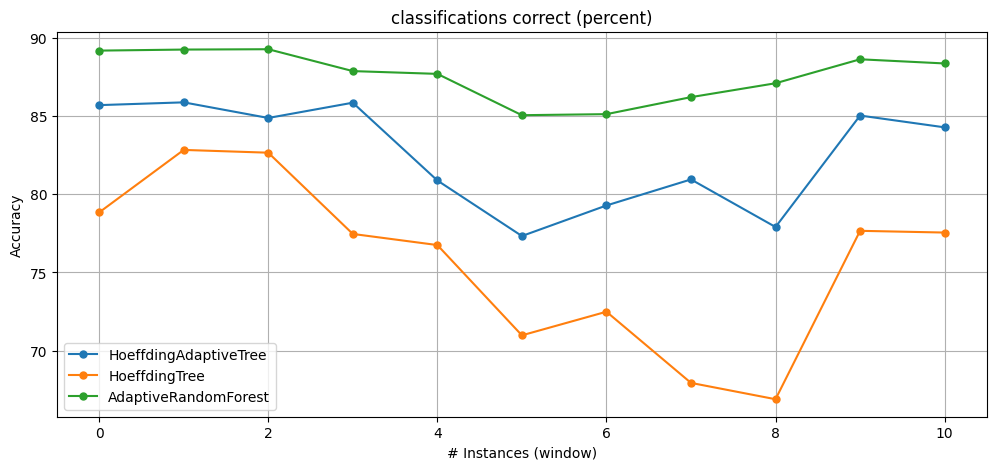

In [6]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.learner import MOAClassifier
from moa.classifiers.trees import HoeffdingAdaptiveTree
from capymoa.learner.classifier import HoeffdingTree
from capymoa.learner.classifier import AdaptiveRandomForest

# Create the wrapper for HoeffdingAdaptiveTree (from MOA)
HAT = MOAClassifier(schema=elec_stream.get_schema(), moa_learner=HoeffdingAdaptiveTree, CLI="-g 50")
HT = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)
ARF = AdaptiveRandomForest(schema=elec_stream.get_schema(), ensemble_size=10, number_of_jobs=4)

results_HAT = prequential_evaluation(stream=elec_stream, learner=HAT, window_size=4500)
results_HT = prequential_evaluation(stream=elec_stream, learner=HT, window_size=4500)
results_ARF = prequential_evaluation(stream=elec_stream, learner=ARF, window_size=4500)

# Comparing models based on their cumulative accuracy
print(f"HAT accuracy = {results_HAT['cumulative'].accuracy()}")
print(f"HT accuracy = {results_HT['cumulative'].accuracy()}")
print(f"ARF accuracy = {results_ARF['cumulative'].accuracy()}")

# Plotting the results. Note that we ovewrote the ylabel, but that doesn't change the metric. 
plot_windowed_results(results_HAT, results_HT, results_ARF, ylabel='Accuracy', xlabel="# Instances (window)")

## 2. Regression

* Regression algorithms have its API usage very similar to classification algorithms. We can use the same high-level evaluation and visualization functions for regression and classification.
* Similarly to classification, we can also use MOA objects through a generic API. 

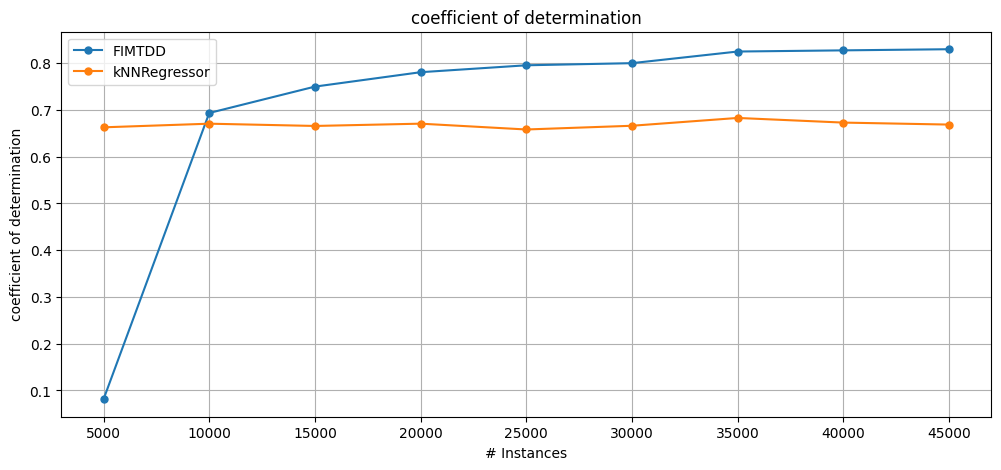

In [7]:
## Open a regression dataset
from moa.classifiers.trees import FIMTDD
from capymoa.learner.learners import MOARegressor
from capymoa.learner.regressor.regressors import KNNRegressor

# Create a learner
fimtdd = MOARegressor(schema=fried_stream.get_schema(), moa_learner=FIMTDD())
# There is a wrapper for KNNRegressor
knnreg = KNNRegressor(schema=fried_stream.get_schema(), k=3, window_size=1000)

results_fimtdd = prequential_evaluation(stream=fried_stream, learner=fimtdd, window_size=5000)
results_knnreg = prequential_evaluation(stream=fried_stream, learner=knnreg, window_size=5000)

results_fimtdd['windowed'].metrics_per_window()
# Selecting the metric so that we don't use the default one. 
    # Note that the metric is different from the ylabel, which overrides the default name of the metric.
plot_windowed_results(results_fimtdd, results_knnreg, metric="coefficient of determination")

## 3. Concept Drift

* One of the most challenging and defining aspects of data streams is the phenomenon known as **concept drifts**.
* In CapyMOA, we designed the simplest and most complete API for simulating, visualizing and assessing concept drifts.
* In the example below we focus on a simple way of simulating and visualizing a drifting stream. There is a tutorial focusing entirely on how Concept Drift can be simulated, detected and assessed in a separate notebook (See ```04_drift_streams.ipynb```)

### 3.1 Plotting Drift Detection results

* This example uses the DriftStream building API, precisely the **positional version** where drifts are specified according to their exact location on the stream.
* **Integration with the visualization function.** The DriftStream object carries meta-information about the drift which is passed along the stream and thus become available to ```plot_windowed_results```

* More details concerning Concept Drift in CapyMOA can be found in the documentation: LINK_CAPYMOA_ORG

None


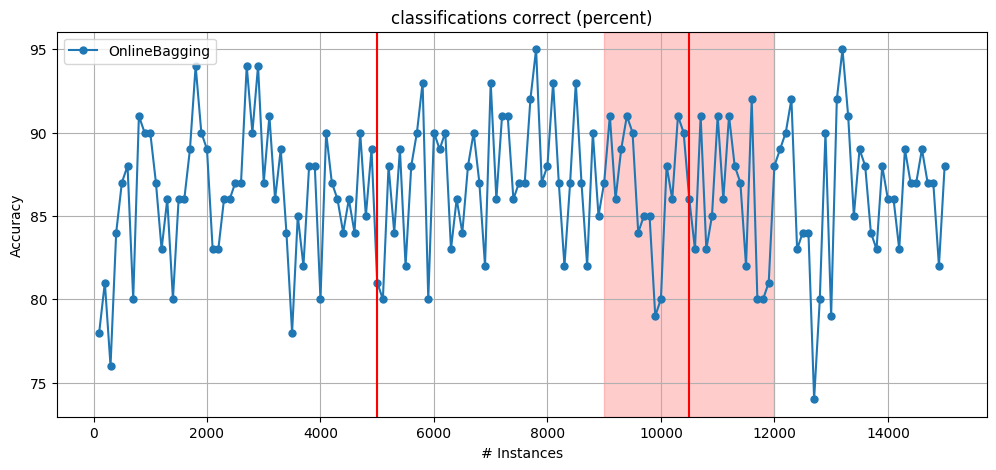

In [11]:
from capymoa.learner.classifier import OnlineBagging
from capymoa.stream.generator import SEA 
from capymoa.stream.drift import Drift, AbruptDrift, GradualDrift, DriftStream

# Generating a synthetic stream with 1 abrupt drift and 1 gradual drift. 
stream_sea2drift = DriftStream(stream=[SEA(function=1), 
                                AbruptDrift(position=5000), 
                                SEA(function=3), 
                                GradualDrift(start=9000, end=12000),
                                SEA(function=1)])

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

# Since this is a synthetic stream, max_instances is needed to determine the amount of instances to be generated. 
results_sea2drift_OB = prequential_evaluation(stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000)

# print(stream_sea2drift.drifts)
plot_windowed_results(results_sea2drift_OB, ylabel='Accuracy')